In [1]:
2+2

4

In [28]:
from Bio import SeqIO
import pandas as pd
from itertools import product
from collections import Counter
import numpy as np

fasta_file = "reference_sequence.fasta"
k = 4

bases = ['A', 'T', 'C', 'G']
kmers = [''.join(p) for p in product(bases, repeat=k)]

def kmer_count(seq, k=k):
    seq = str(seq).upper()
    counts = Counter([seq[i:i+k] for i in range(len(seq)-k+1)])
    return [counts.get(kmer, 0) for kmer in kmers]

# Load FASTA and convert to embeddings
embeddings = []
seq_ids = []

for record in SeqIO.parse(fasta_file, "fasta"):
    seq_ids.append(record.id)
    embeddings.append(kmer_count(record.seq))

# Convert to DataFrame
df = pd.DataFrame(embeddings, index=seq_ids, columns=kmers)
df.head()

# Optional: Normalize vectors
# df_normalized = df.div(df.sum(axis=1), axis=0)

# print(df_normalized.head())


,AAAA,AAAT,AAAC,AAAG,AATA,AATT,AATC,AATG,AACA,AACT,...,GGTC,GGTG,GGCA,GGCT,GGCC,GGCG,GGGA,GGGT,GGGC,GGGG
NG_242829.1,9,7,6,6,9,13,4,4,1,5,...,4,5,4,6,6,3,9,6,7,11
NG_242814.1,8,10,6,5,13,10,8,3,4,8,...,4,7,6,4,5,3,8,7,4,10
NG_242813.1,8,10,5,5,13,9,8,3,4,8,...,4,7,5,4,5,4,8,7,5,10
NG_228708.1,8,10,4,5,13,9,8,3,4,8,...,4,9,4,4,5,3,8,8,4,10
NG_077399.1,10,7,6,6,8,10,5,3,1,5,...,3,5,4,6,7,4,7,6,8,10


In [4]:
import pandas as pd
import umap
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
reducer = umap.UMAP(random_state = 42)
embedding_ed = reducer.fit_transform(df_normalized)

c:\Users\ASUS\miniconda3\envs\sdenv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ASUS\miniconda3\envs\sdenv\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


In [7]:
df_umap = pd.DataFrame(embedding_ed, columns=["UMAP1", "UMAP2"], index=df.index)

In [8]:
clusterer = hdbscan.HDBSCAN(min_cluster_size = 5)
labels = clusterer.fit_predict(df_umap)

c:\Users\ASUS\miniconda3\envs\sdenv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\miniconda3\envs\sdenv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [10]:
df_umap["Cluster"] = labels
print(df_umap.head())

                 UMAP1     UMAP2  Cluster
NG_242829.1   7.145488 -3.698658       -1
NG_242814.1  19.602465 -3.103360       -1
NG_242813.1  19.690285 -3.073868       -1
NG_228708.1  19.647558 -3.116585       -1
NG_077399.1   2.765335  1.631758      141


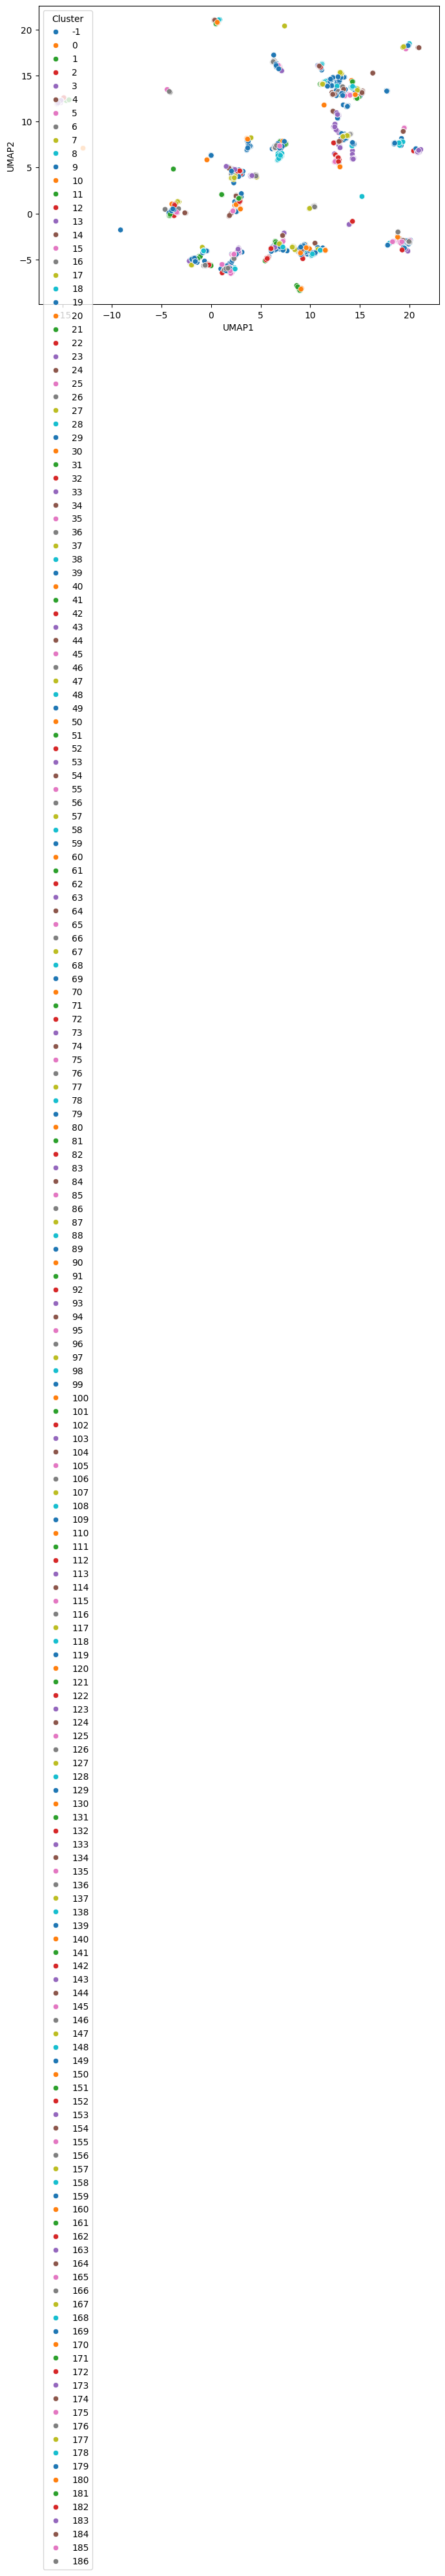

In [11]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="UMAP1", y="UMAP2", hue="Cluster", data=df_umap, palette="tab10")
plt.show()


In [13]:
from Bio import SeqIO

# Load reference sequences
reference_sequences = list(SeqIO.parse("reference_sequence.fasta", "fasta"))

# Load your eDNA sequences
edna_sequences = list(SeqIO.parse("edna_sequence.fasta", "fasta"))


In [ ]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

def annotate_sequence(query_seq, references, threshold=80):
    """
    Annotates a query sequence by aligning with reference sequences.
    Returns the best matching reference if identity >= threshold%.
    """
    best_match = None
    best_score = 0

    for ref in references:
        alignments = pairwise2.align.localms(query_seq, str(ref.seq), 2, -1, -0.5, -0.1)
        score = alignments[0].score / max(len(query_seq), len(ref.seq)) * 100  # percent identity
        if score > best_score:
            best_score = score
            best_match = ref.id

    if best_score >= threshold:
        return best_match, best_score
    else:
        return "No match", best_score


c:\Users\ASUS\miniconda3\envs\sdenv\Lib\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [ ]:
from Bio import SeqIO
from collections import Counter

def get_kmers(seq, k=10):
    return [seq[i:i+k] for i in range(len(seq)-k+1)]

def annotate_by_kmer(query_seq, reference_sequences, k=10):
    query_kmers = Counter(get_kmers(query_seq, k))
    best_match = "No match"
    best_score = 0

    for ref in reference_sequences:
        ref_kmers = Counter(get_kmers(str(ref.seq), k))
        # Count number of shared k-mers
        shared = sum((query_kmers & ref_kmers).values())
        if shared > best_score:
            best_score = shared
            best_match = ref.id

    return best_match, best_score


In [24]:
reference_sequences = list(SeqIO.parse("reference_sequence.fasta", "fasta"))
edna_sequences = list(SeqIO.parse("edna_sequence.fasta", "fasta"))


In [25]:
import pandas as pd

results = []
for seq_record in edna_sequences:
    ref_id, score = annotate_by_kmer(str(seq_record.seq), reference_sequences, k=10)
    results.append({
        "Query_ID": seq_record.id,
        "Best_Reference": ref_id,
        "Shared_Kmers": score
    })

df = pd.DataFrame(results)
df.to_csv("edna_annotation_results_kmer_simple.csv", index=False)
print("Annotation complete! Results saved to 'edna_annotation_results_kmer_simple.csv'")


Annotation complete! Results saved to 'edna_annotation_results_kmer_simple.csv'


In [26]:
import pandas as pd
df = pd.read_csv("edna_annotation_results_kmer_simple.csv")
print(df.head())


                      Query_ID Best_Reference  Shared_Kmers
0  NC_133693.1:4126340-4130105    NG_070318.1            20


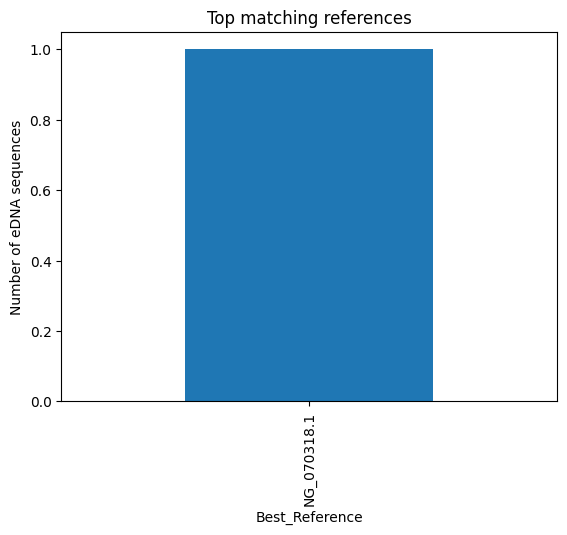

In [27]:
import matplotlib.pyplot as plt

top_refs = df['Best_Reference'].value_counts().head(10)
top_refs.plot(kind='bar')
plt.ylabel("Number of eDNA sequences")
plt.title("Top matching references")
plt.show()
